In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re

In [3]:
# Get the burstiness values based on the files present in the directory
results_dir = 'results'
file_pattern = re.compile(r'response_times_burstiness_(\d+\.\d+).csv')
burstiness_values = []

for filename in os.listdir(results_dir):
    match = file_pattern.match(filename)
    if match:
        burstiness_values.append(float(match.group(1)))

burstiness_values.sort()
burstiness_values

[1.1, 1.3, 2.0, 5.0, 10.0, 20.0, 70.0, 100.0]

In [4]:
# Load the data from the CSV files
data_frames = []

for burstiness in burstiness_values:
    file_path = os.path.join(results_dir, f'response_times_burstiness_{burstiness}.csv')
    if os.path.exists(file_path):
        df = pd.read_csv(file_path)
        data_frames.append(df)

# Combine the data into a single DataFrame
combined_df = pd.concat(data_frames, ignore_index=True)
combined_df

,sourceId,time,responseTime,burstiness
0,2,0.040213,0.000095,1.1
1,2,0.080074,0.000090,1.1
2,2,0.120037,0.000089,1.1
3,2,0.160008,0.000086,1.1
4,1,0.169040,0.000130,1.1
...,...,...,...,...
278800,2,999.890928,0.044337,100.0
278801,2,999.920008,0.044336,100.0
278802,1,999.988798,0.044377,100.0
278803,2,999.994962,0.044334,100.0


In [5]:
# Map source IDs to names
source_names = {1: 'Poisson source', 2: 'Constant source', 3: 'Bursty source'}
combined_df['sourceName'] = combined_df['sourceId'].map(source_names)

In [6]:
average_response_times = combined_df.groupby(['sourceId', 'burstiness'])['responseTime'].mean().reset_index()
average_response_times['sourceName'] = average_response_times['sourceId'].map(source_names)

In [7]:
from scipy import stats

# Compute the confidence intervals
ci_lower = []
ci_upper = []

for name, group in combined_df.groupby(['sourceId', 'burstiness']):
    ci = stats.t.interval(0.95, len(group['responseTime'])-1, loc=group['responseTime'].mean(), scale=stats.sem(group['responseTime']))
    ci_lower.append(ci[0])
    ci_upper.append(ci[1])

average_response_times['ci_lower'] = ci_lower
average_response_times['ci_upper'] = ci_upper

average_response_times

,sourceId,burstiness,responseTime,sourceName,ci_lower,ci_upper
0,1,1.1,0.000143,Poisson source,0.000143,0.000143
1,1,1.3,0.000152,Poisson source,0.000152,0.000152
2,1,2.0,0.000247,Poisson source,0.000247,0.000247
3,1,5.0,0.001424,Poisson source,0.001424,0.001425
4,1,10.0,0.003595,Poisson source,0.003593,0.003597
5,1,20.0,0.008051,Poisson source,0.008036,0.008067
6,1,70.0,0.028656,Poisson source,0.028622,0.028689
7,1,100.0,0.043652,Poisson source,0.043430,0.043874
8,2,1.1,0.000098,Constant source,0.000098,0.000098
9,2,1.3,0.000107,Constant source,0.000107,0.000107


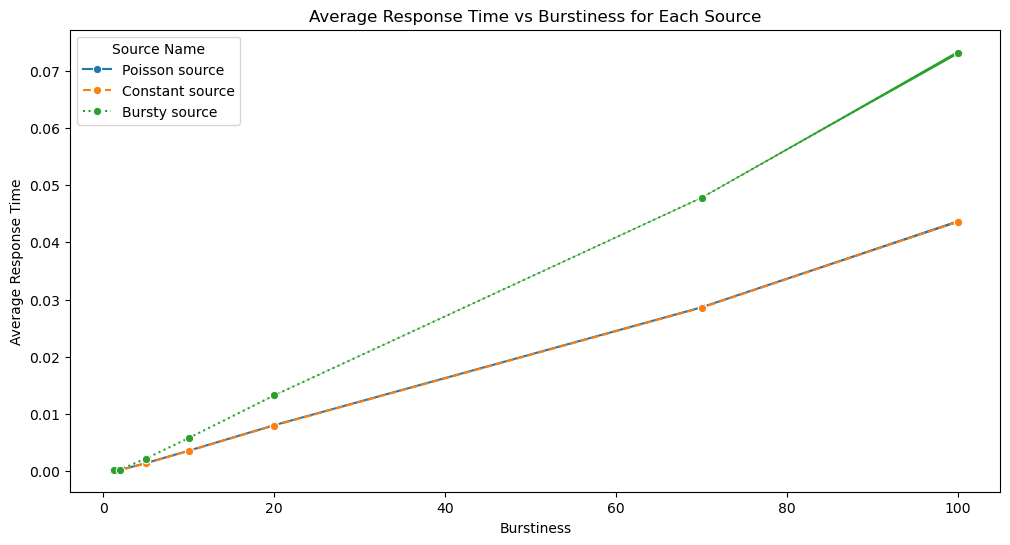

In [16]:
# Plot the average response time for each source with respect to burstiness
plt.figure(figsize=(12, 6))

# Define line styles for each source
line_styles = {'Poisson source': 'solid', 'Constant source': 'dashed', 'Bursty source': 'dotted'}

# Plot each source with a different line style and add confidence intervals
for source, style in line_styles.items():
    source_data = average_response_times[average_response_times['sourceName'] == source]
    sns.lineplot(x='burstiness', y='responseTime', data=source_data, label=source, linestyle=style, marker='o')
    plt.fill_between(source_data['burstiness'], source_data['ci_lower'], source_data['ci_upper'], alpha=1)

plt.title('Average Response Time vs Burstiness for Each Source')
plt.xlabel('Burstiness')
plt.ylabel('Average Response Time')
plt.legend(title='Source Name')
plt.show()

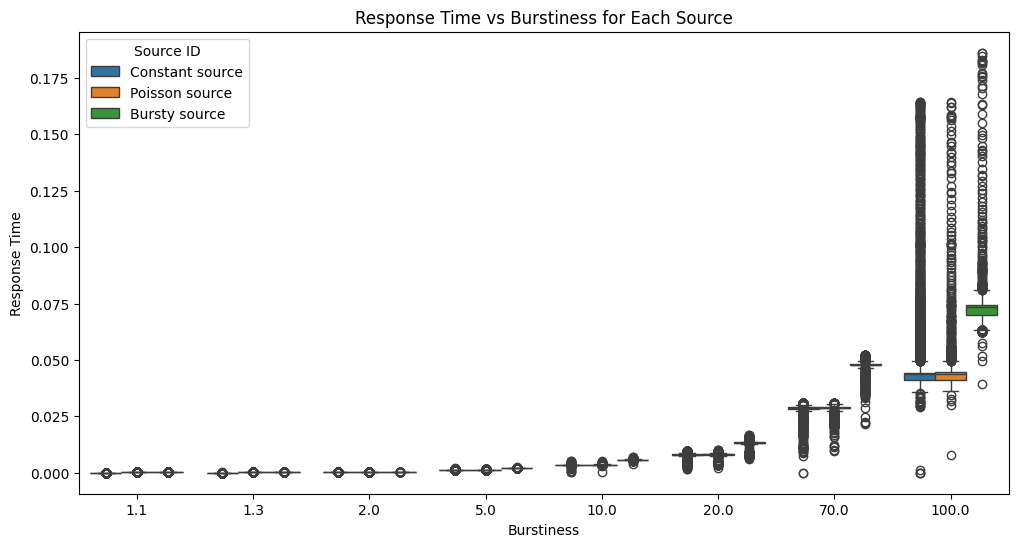

In [7]:
# Plot separate box plots for each source
plt.figure(figsize=(12, 6))
sns.boxplot(x='burstiness', y='responseTime', hue='sourceName', data=combined_df)
plt.title('Response Time vs Burstiness for Each Source')
plt.xlabel('Burstiness')
plt.ylabel('Response Time')
plt.legend(title='Source ID')
plt.show()

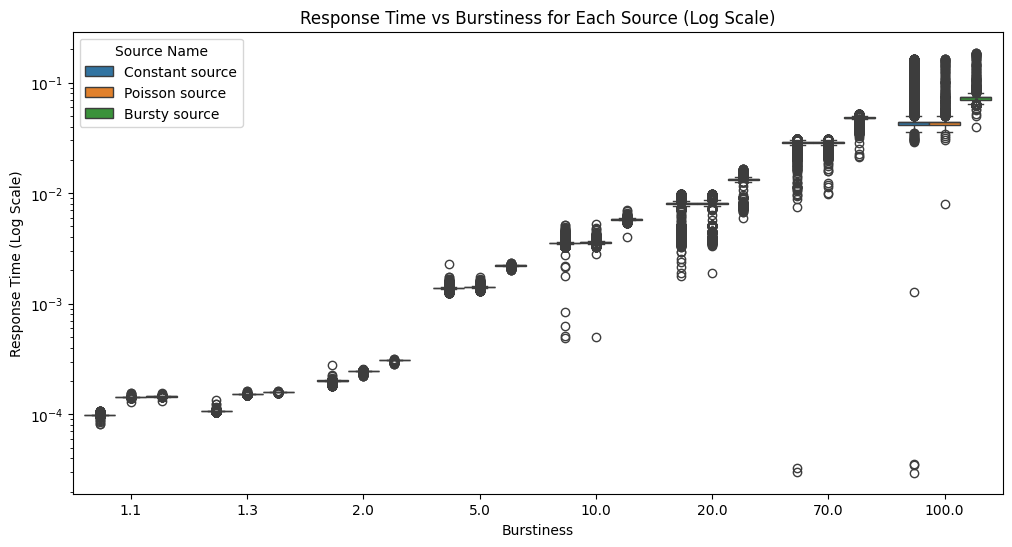

In [8]:
# Plot separate box plots for each source with a log scale on the y-axis
plt.figure(figsize=(12, 6))
sns.boxplot(x='burstiness', y='responseTime', hue='sourceName', data=combined_df)
plt.yscale('log')
plt.title('Response Time vs Burstiness for Each Source (Log Scale)')
plt.xlabel('Burstiness')
plt.ylabel('Response Time (Log Scale)')
plt.legend(title='Source Name')
plt.show()